# SageMaker PySpark K-Means Clustering MNIST Example

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Loading the Data](#Loading-the-Data)
4. [Training with K-Means and Hosting a Model](#Training-with-K-Means-and-Hosting-a-Model)
5. [Inference](#Inference)
8. [Re-using existing endpoints or models to create a SageMakerModel](#Re-using-existing-endpoints-or-models-to-create-SageMakerModel)
9. [Clean-up](#Clean-up)
10. [More on SageMaker Spark](#More-on-SageMaker-Spark)

## Introduction
This notebook will show how to cluster handwritten digits through the SageMaker PySpark library. 

We will manipulate data through Spark using a SparkSession, and then use the SageMaker Spark library to interact with SageMaker for training and inference. 
We will first train on SageMaker using K-Means clustering on the MNIST dataset. Then, we will see how to re-use models from existing endpoints and from a model stored on S3 in order to only run inference. 

You can visit SageMaker Spark's GitHub repository at https://github.com/aws/sagemaker-spark to learn more about SageMaker Spark.

This notebook was created and tested on an ml.m4.xlarge notebook instance.

## Setup

First, we import the necessary modules and create the `SparkSession` with the SageMaker-Spark dependencies attached. 

In [1]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github to learn how to connect to EMR from a notebook instance
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()
    
spark

## Loading the Data

Now, we load the MNIST dataset into a Spark Dataframe, which dataset is available in LibSVM format at

`s3://sagemaker-sample-data-[region]/spark/mnist/`

where `[region]` is replaced with a supported AWS region, such as us-east-1.

In order to train and make inferences our input DataFrame must have a column of Doubles (named "label" by default) and a column of Vectors of Doubles (named "features" by default).

Spark's LibSVM DataFrameReader loads a DataFrame already suitable for training and inference.

Here, we load into a DataFrame in the SparkSession running on the local Notebook Instance, but you can connect your Notebook Instance to a remote Spark cluster for heavier workloads. Starting from EMR 5.11.0, SageMaker Spark is pre-installed on EMR Spark clusters. For more on connecting your SageMaker Notebook Instance to a remote EMR cluster, please see [this blog post](https://aws.amazon.com/blogs/machine-learning/build-amazon-sagemaker-notebooks-backed-by-spark-in-amazon-emr/).

In [2]:
import boto3

region = boto3.Session().region_name
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 's3.{}.amazonaws.com'.format(region))

trainingData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/train/'.format(region))

testData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/test/'.format(region))

trainingData.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  5.0|(784,[152,153,154...|
|  0.0|(784,[127,128,129...|
|  4.0|(784,[160,161,162...|
|  1.0|(784,[158,159,160...|
|  9.0|(784,[208,209,210...|
|  2.0|(784,[155,156,157...|
|  1.0|(784,[124,125,126...|
|  3.0|(784,[151,152,153...|
|  1.0|(784,[152,153,154...|
|  4.0|(784,[134,135,161...|
|  3.0|(784,[123,124,125...|
|  5.0|(784,[216,217,218...|
|  3.0|(784,[143,144,145...|
|  6.0|(784,[72,73,74,99...|
|  1.0|(784,[151,152,153...|
|  7.0|(784,[211,212,213...|
|  2.0|(784,[151,152,153...|
|  8.0|(784,[159,160,161...|
|  6.0|(784,[100,101,102...|
|  9.0|(784,[209,210,211...|
+-----+--------------------+
only showing top 20 rows



MNIST images are 28x28, resulting in 784 pixels. The dataset consists of images of digits going from 0 to 9, representing 10 classes. 

In each row:
* The `label` column identifies the image's label. For example, if the image of the handwritten number is the digit 5, the label value is 5.
* The `features` column stores a vector (`org.apache.spark.ml.linalg.Vector`) of `Double` values. The length of the vector is 784, as each image consists of 784 pixels. Those pixels are the features we will use. 



As we are interested in clustering the images of digits, the number of pixels represents the feature vector, while the number of classes represents the number of clusters we want to find. 

## Training with K-Means and Hosting a Model
Now we create a KMeansSageMakerEstimator, which uses the KMeans Amazon SageMaker Algorithm to train on our input data, and uses the KMeans Amazon SageMaker model image to host our model.

Calling fit() on this estimator will train our model on Amazon SageMaker, and then create an Amazon SageMaker Endpoint to host our model.

We can then use the SageMakerModel returned by this call to fit() to transform Dataframes using our hosted model.

The following cell runs a training job and creates an endpoint to host the resulting model, so this cell can take up to twenty minutes to complete.

In [3]:
from sagemaker_pyspark import IAMRole
from sagemaker_pyspark.algorithms import KMeansSageMakerEstimator
from sagemaker_pyspark import RandomNamePolicyFactory

# Create K-Means Estimator
kmeans_estimator = KMeansSageMakerEstimator(
    sagemakerRole = IAMRole(role),
    trainingInstanceType = 'ml.m4.xlarge', # Instance type to train K-means on SageMaker
    trainingInstanceCount = 1,
    endpointInstanceType = 'ml.t2.large', # Instance type to serve model (endpoint) for inference
    endpointInitialInstanceCount = 1,
    namePolicyFactory = RandomNamePolicyFactory("sparksm-1a-")) # All the resources created are prefixed with sparksm-1

# Set parameters for K-Means
kmeans_estimator.setFeatureDim(784)
kmeans_estimator.setK(10)

# Train
initialModel = kmeans_estimator.fit(trainingData)

To put this `KMeansSageMakerEstimator` back into context, let's look at the below architecture that shows what actually runs on the notebook instance and on SageMaker.

![Hey](img/sagemaker-spark-kmeans-architecture.png)

We'll need the name of the SageMaker endpoint hosting the K-Means model later on. This information can be accessed directly within the `SageMakerModel`. 

In [4]:
initialModelEndpointName = initialModel.endpointName
print(initialModelEndpointName)

sparksm-1a-endpoint-ab5d1fa330db-2020-04-08T17-53-43-625


## Inference

Now we transform our DataFrame.
To do this, we serialize each row's "features" Vector of Doubles into a Protobuf format for inference against the Amazon SageMaker Endpoint. We deserialize the Protobuf responses back into our DataFrame. This serialization and deserialization is handled automatically by the `transform()` method:

In [5]:
# Run inference on the test data and show some results
transformedData = initialModel.transform(testData)

transformedData.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...| 1395.2342529296875|            7.0|
|  2.0|(784,[94,95,96,97...|  2043.432373046875|            6.0|
|  1.0|(784,[128,129,130...|  966.5573120117188|            5.0|
|  0.0|(784,[124,125,126...|  1600.843994140625|            3.0|
|  4.0|(784,[150,151,159...| 1372.9215087890625|            2.0|
|  1.0|(784,[156,157,158...|  852.9239501953125|            5.0|
|  4.0|(784,[149,150,151...|  1655.786376953125|            7.0|
|  9.0|(784,[179,180,181...| 1702.6414794921875|            2.0|
|  5.0|(784,[129,130,131...|  2081.819580078125|            6.0|
|  9.0|(784,[209,210,211...| 1579.3565673828125|            7.0|
|  0.0|(784,[123,124,125...| 1577.8565673828125|            3.0|
|  6.0|(784,[94,95,96,97...| 2001.2979736328125|            4.0|
|  9.0|(784,[208,209,210.

How well did the algorithm perform? Let us display the digits from each of the clusters and manually inspect the results:




Cluster A:


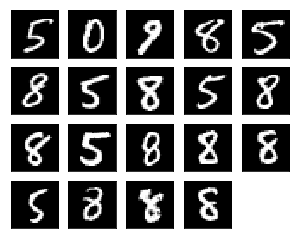




Cluster B:


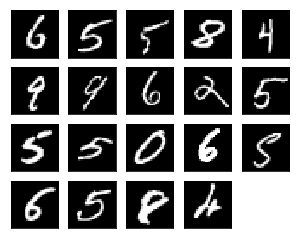




Cluster C:


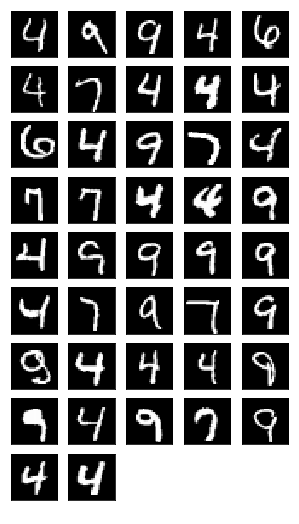




Cluster D:


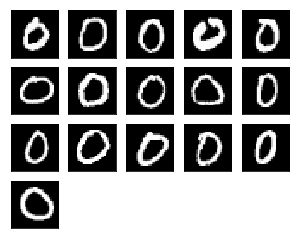




Cluster E:


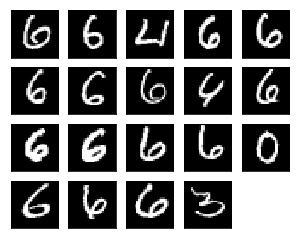




Cluster F:


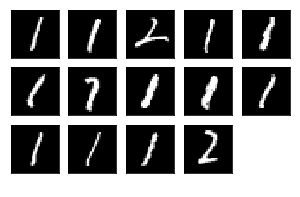




Cluster G:


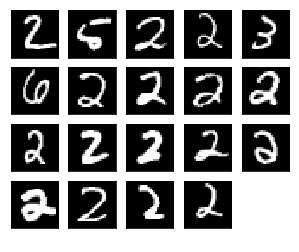




Cluster H:


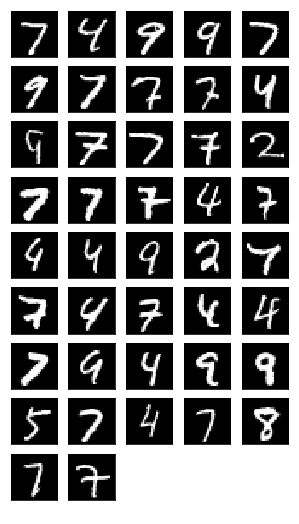




Cluster I:


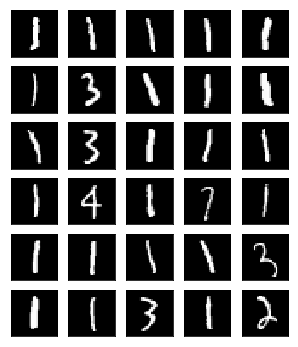




Cluster J:


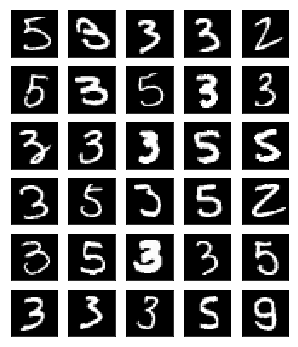

In [7]:
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np
import string

# Helper function to display a digit
def showDigit(img, caption='', xlabel='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axes.get_xaxis().set_ticks([])
    subplot.axes.get_yaxis().set_ticks([])
    plt.title(caption)
    plt.xlabel(xlabel)
    subplot.imshow(imgr, cmap='gray')
    
def displayClusters(data):
    images = np.array(data.select("features").cache().take(250))
    clusters = data.select("closest_cluster").cache().take(250)

    for cluster in range(10):
        print('\n\n\nCluster {}:'.format(string.ascii_uppercase[cluster]))
        digits = [ img for l, img in zip(clusters, images) if int(l.closest_cluster) == cluster ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showDigit(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()
        
displayClusters(transformedData)

Now that we've seen how to use Spark to load data and SageMaker to train and infer on it, we will look into creating pipelines consisting of multiple algorithms, both from SageMaker-provided algorithms as well as from Spark MLlib. 

## Re-using existing endpoints or models to create `SageMakerModel`

SageMaker Spark supports connecting a `SageMakerModel` to an existing SageMaker endpoint, or to an Endpoint created by reference to model data in S3, or to a previously completed Training Job.

This allows you to use SageMaker Spark just for model hosting and inference on Spark-scale DataFrames without running a new Training Job.

### Endpoint re-use

Here we will connect to the initial endpoint we created by using it's unique name. The endpoint name can either be retrieved by the console or in in the `endpointName` parameter of the model you created. In our case, we saved this early on in a variable by accessing the parameter.

In [8]:
ENDPOINT_NAME = initialModelEndpointName
print(ENDPOINT_NAME)

sparksm-1a-endpoint-ab5d1fa330db-2020-04-08T17-53-43-625


Once you have the name of the endpoint, we need to make sure that no endpoint will be created as we are attaching to an existing endpoint. This is done using `endpointCreationPolicy` field with a value of `EndpointCreationPolicy.DO_NOT_CREATE`. As we are using an endpoint serving a K-Means model, we also need to use the `KMeansProtobufResponseRowDeserializer` so that the output of the endpoint on SageMaker will be deserialized in the right way and passed on back to Spark in a DataFrame with the right columns. 

In [9]:
from sagemaker_pyspark import SageMakerModel
from sagemaker_pyspark import EndpointCreationPolicy
from sagemaker_pyspark.transformation.serializers import ProtobufRequestRowSerializer
from sagemaker_pyspark.transformation.deserializers import KMeansProtobufResponseRowDeserializer

attachedModel = SageMakerModel(
    existingEndpointName = ENDPOINT_NAME,
    endpointCreationPolicy = EndpointCreationPolicy.DO_NOT_CREATE,
    endpointInstanceType = None, # Required
    endpointInitialInstanceCount = None, # Required
    requestRowSerializer = ProtobufRequestRowSerializer(featuresColumnName = "features"), # Optional: already default value
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer( # Optional: already default values
      distance_to_cluster_column_name = "distance_to_cluster",
      closest_cluster_column_name = "closest_cluster")
)

As the data we are passing through the model is using the default columns naming for both the input to the model (`features`) and for the ouput of the model (`distance_to_cluster_column_name` and `closest_cluster_column_name`), we do not need to specify the names of the columns in the serializer and deserializer. If your column naming is different, it's possible to define the name of the columns as shown above in the `requestRowSerializer` and `responseRowDeserializer`. 

It is also possible to use the `SageMakerModel.fromEndpoint` method to perform the same as above. 

In [10]:
transformedData2 = attachedModel.transform(testData)
transformedData2.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...| 1395.2342529296875|            7.0|
|  2.0|(784,[94,95,96,97...|  2043.432373046875|            6.0|
|  1.0|(784,[128,129,130...|  966.5573120117188|            5.0|
|  0.0|(784,[124,125,126...|  1600.843994140625|            3.0|
|  4.0|(784,[150,151,159...| 1372.9215087890625|            2.0|
|  1.0|(784,[156,157,158...|  852.9239501953125|            5.0|
|  4.0|(784,[149,150,151...|  1655.786376953125|            7.0|
|  9.0|(784,[179,180,181...| 1702.6414794921875|            2.0|
|  5.0|(784,[129,130,131...|  2081.819580078125|            6.0|
|  9.0|(784,[209,210,211...| 1579.3565673828125|            7.0|
|  0.0|(784,[123,124,125...| 1577.8565673828125|            3.0|
|  6.0|(784,[94,95,96,97...| 2001.2979736328125|            4.0|
|  9.0|(784,[208,209,210.

### Create model and endpoint from model data

You can create a SageMakerModel and an Endpoint by referring directly to your model data in S3. To do this, you need the path to where the model is saved (in our case on S3), as well as the role and the inference image to use. In our case, we use the model data from the initial model, consisting of a simple K-Means model. We can retrieve the necessary information from the model variable, or through the console. 

In [31]:
from sagemaker_pyspark import S3DataPath

MODEL_S3_PATH = S3DataPath(initialModel.modelPath.bucket, initialModel.modelPath.objectPath)
MODEL_ROLE_ARN = initialModel.modelExecutionRoleARN
MODEL_IMAGE_PATH = initialModel.modelImage

print(MODEL_S3_PATH.bucket + MODEL_S3_PATH.objectPath)
print(MODEL_ROLE_ARN)
print(MODEL_IMAGE_PATH)

380587195682-sagemaker-us-east-24706e810-893e-40c4-8307-58eb56d4da09/sparksm-1a-trainingJob-ab5d1fa330db-2020-04-08T17-53-43-625/sparksm-1a-trainingJob-ab5d1fa330db-2020-04-08T17-53-43-625/output/model.tar.gz
arn:aws:iam::380587195682:role/service-role/AmazonSageMaker-ExecutionRole-20190619T123079
404615174143.dkr.ecr.us-east-2.amazonaws.com/kmeans:1


Similar to how we created a model from a running endpoint, we specify the model data information using `modelPath`, `modelExecutionRoleARN`, `modelImage`. This method is more akin to creating a `SageMakerEstimator`, where among others you specify the endpoint information. 

In [12]:
from sagemaker_pyspark import RandomNamePolicy

retrievedModel = SageMakerModel(
    modelPath = MODEL_S3_PATH,
    modelExecutionRoleARN = MODEL_ROLE_ARN,
    modelImage = MODEL_IMAGE_PATH,
    endpointInstanceType = "ml.t2.medium",
    endpointInitialInstanceCount = 1,
    requestRowSerializer = ProtobufRequestRowSerializer(), 
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer(),
    namePolicy = RandomNamePolicy("sparksm-1b-"), 
    endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

It is also possible to use the `SageMakerModel.fromModelS3Path` method that takes the same parameters and produces the same model. 

In [13]:
transformedData3 = retrievedModel.transform(testData)
transformedData3.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...| 1395.2342529296875|            7.0|
|  2.0|(784,[94,95,96,97...|  2043.432373046875|            6.0|
|  1.0|(784,[128,129,130...|  966.5573120117188|            5.0|
|  0.0|(784,[124,125,126...|  1600.843994140625|            3.0|
|  4.0|(784,[150,151,159...| 1372.9215087890625|            2.0|
|  1.0|(784,[156,157,158...|  852.9239501953125|            5.0|
|  4.0|(784,[149,150,151...|  1655.786376953125|            7.0|
|  9.0|(784,[179,180,181...| 1702.6414794921875|            2.0|
|  5.0|(784,[129,130,131...|  2081.819580078125|            6.0|
|  9.0|(784,[209,210,211...| 1579.3565673828125|            7.0|
|  0.0|(784,[123,124,125...| 1577.8565673828125|            3.0|
|  6.0|(784,[94,95,96,97...| 2001.2979736328125|            4.0|
|  9.0|(784,[208,209,210.

### Create model and endpoint from job training data

You can create a SageMakerModel and an Endpoint by referring to a previously-completed training job. Only difference with the model data from S3 is that instead of providing the model data, you provide the `trainingJobName`. 

In [32]:
TRAINING_JOB_NAME = "sparksm-1a-trainingJob-ab5d1fa330db-2020-04-08T17-53-43-625"
MODEL_ROLE_ARN = initialModel.modelExecutionRoleARN
MODEL_IMAGE_PATH = initialModel.modelImage

In [33]:
modelFromJob = SageMakerModel.fromTrainingJob(
    trainingJobName = TRAINING_JOB_NAME,
    modelExecutionRoleARN = MODEL_ROLE_ARN,
    modelImage = MODEL_IMAGE_PATH,
    endpointInstanceType = "ml.t2.medium",
    endpointInitialInstanceCount = 1,
    requestRowSerializer = ProtobufRequestRowSerializer(), 
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer(),
    namePolicy = RandomNamePolicy("sparksm-1c-"),
    endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

In [34]:
transformedData4 = modelFromJob.transform(testData)
transformedData4.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...| 1395.2342529296875|            7.0|
|  2.0|(784,[94,95,96,97...|  2043.432373046875|            6.0|
|  1.0|(784,[128,129,130...|  966.5573120117188|            5.0|
|  0.0|(784,[124,125,126...|  1600.843994140625|            3.0|
|  4.0|(784,[150,151,159...| 1372.9215087890625|            2.0|
|  1.0|(784,[156,157,158...|  852.9239501953125|            5.0|
|  4.0|(784,[149,150,151...|  1655.786376953125|            7.0|
|  9.0|(784,[179,180,181...| 1702.6414794921875|            2.0|
|  5.0|(784,[129,130,131...|  2081.819580078125|            6.0|
|  9.0|(784,[209,210,211...| 1579.3565673828125|            7.0|
|  0.0|(784,[123,124,125...| 1577.8565673828125|            3.0|
|  6.0|(784,[94,95,96,97...| 2001.2979736328125|            4.0|
|  9.0|(784,[208,209,210.

## XGBoost Model Comparison

In [36]:
from sagemaker_pyspark.algorithms import XGBoostSageMakerEstimator

xgboost_estimator = XGBoostSageMakerEstimator(
    trainingInstanceType="ml.m4.xlarge", # Instance type to train xgboost on SageMaker
    trainingInstanceCount=1,
    endpointInstanceType="ml.m4.xlarge", # Instance type to serve model (endpoint) for inference
    endpointInitialInstanceCount=1,
    sagemakerRole=IAMRole(role))

xgboost_estimator.setObjective('multi:softmax')
xgboost_estimator.setNumRound(25)
xgboost_estimator.setNumClasses(10)

xgboost_model = xgboost_estimator.fit(trainingData)

### Results

In [38]:

transformed_data = xgboost_model.transform(testData)
transformed_data.show()

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|  7.0|(784,[202,203,204...|       7.0|
|  2.0|(784,[94,95,96,97...|       2.0|
|  1.0|(784,[128,129,130...|       1.0|
|  0.0|(784,[124,125,126...|       0.0|
|  4.0|(784,[150,151,159...|       4.0|
|  1.0|(784,[156,157,158...|       1.0|
|  4.0|(784,[149,150,151...|       4.0|
|  9.0|(784,[179,180,181...|       9.0|
|  5.0|(784,[129,130,131...|       5.0|
|  9.0|(784,[209,210,211...|       9.0|
|  0.0|(784,[123,124,125...|       0.0|
|  6.0|(784,[94,95,96,97...|       6.0|
|  9.0|(784,[208,209,210...|       9.0|
|  0.0|(784,[152,153,154...|       0.0|
|  1.0|(784,[125,126,127...|       1.0|
|  5.0|(784,[124,125,126...|       5.0|
|  9.0|(784,[179,180,181...|       9.0|
|  7.0|(784,[200,201,202...|       7.0|
|  3.0|(784,[118,119,120...|       3.0|
|  4.0|(784,[158,159,185...|       4.0|
+-----+--------------------+----------+
only showing top 20 rows



### Visual Comparison




Prediction A:


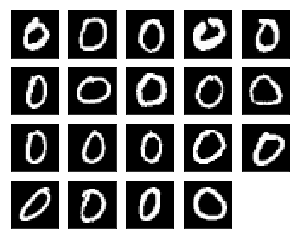




Prediction B:


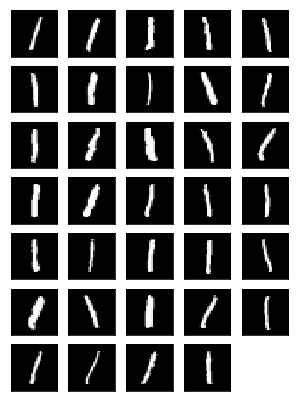




Prediction C:


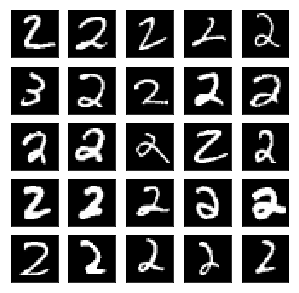




Prediction D:


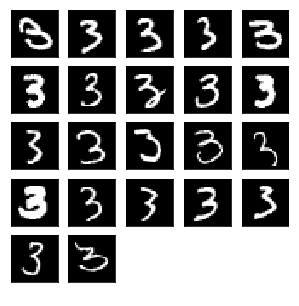




Prediction E:


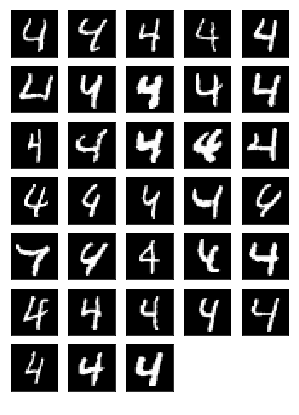




Prediction F:


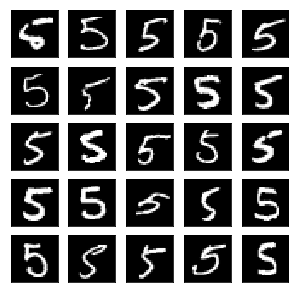




Prediction G:


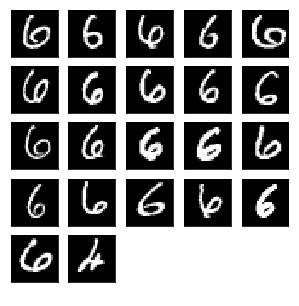




Prediction H:


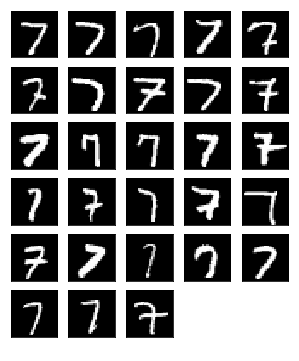




Prediction I:


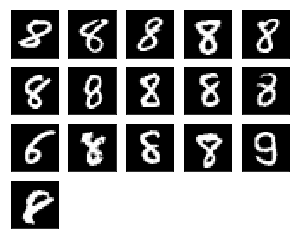




Prediction J:


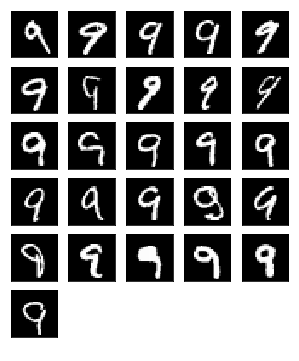

In [40]:
def showDigit(img, caption='', xlabel='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axes.get_xaxis().set_ticks([])
    subplot.axes.get_yaxis().set_ticks([])
    plt.title(caption)
    plt.xlabel(xlabel)
    subplot.imshow(imgr, cmap='gray')
    
def displayPredictions(data):
    images = np.array(data.select("features").cache().take(250))
    preds = data.select("prediction").cache().take(250)

    for pred in range(10):
        print('\n\n\nPrediction {}:'.format(string.ascii_uppercase[pred]))
        digits = [ img for l, img in zip(preds, images) if int(l.prediction) == pred ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showDigit(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()
        
displayPredictions(transformed_data)

### Conclusions

As we can see through the AUC for the ROC and the visualizations themselves, XGBoost performed substantially better in both speed and accuracy.



## Clean-up

Since we don't need to make any more inferences, now we delete the resources (endpoints, models, configurations, etc):

In [ ]:
# Delete the resources
from sagemaker_pyspark import SageMakerResourceCleanup

def cleanUp(model):
    resource_cleanup = SageMakerResourceCleanup(model.sagemakerClient)
    resource_cleanup.deleteResources(model.getCreatedResources())

# Don't forget to include any models or pipeline models that you created in the notebook
models = [initialModel, retrievedModel, modelFromJob]

# Delete regular SageMakerModels
for m in models:
    cleanUp(m)

## More on SageMaker Spark

The SageMaker Spark Github repository has more about SageMaker Spark, including how to use SageMaker Spark using the Scala SDK: https://github.com/aws/sagemaker-spark
